In [3]:
import copy
import gc
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import segmentation_models_pytorch as smp
import time
import torch
import torch.nn.functional as F
import torch.utils.data as data

from pathlib import Path
from PIL import Image
from torch import nn
from torchsummary import summary
from tqdm.notebook import tqdm

torch.cuda.empty_cache()

In [ ]:
#Load training and validation images and masks


TR_IMG_PATH = '/content/HAM10000_images_split/train'
TR_MASK_PATH = '/content/HAM10000_segmentations_split/train'
VAL_IMG_PATH = '/content/HAM10000_images_split/val'
VAL_MASK_PATH = '/content/HAM10000_segmentations_split/val'

class SegmentationLoader(data.Dataset):
    def __init__(self, flag):
        super(SegmentationLoader, self).__init__()
        if flag == 'train':
            IMAGE_PATH = TR_IMG_PATH
            MASK_PATH = TR_MASK_PATH
        if flag == 'val':
            IMAGE_PATH = VAL_IMG_PATH
            MASK_PATH = VAL_MASK_PATH
        self.img_files = glob.glob(os.path.join(IMAGE_PATH, '*.jpg'))
        self.mask_files = []
        for img_path in self.img_files:
            self.mask_files.append(os.path.join(MASK_PATH, Path(img_path).stem) + '_segmentation.jpg')

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        data = Image.open(img_path)
        data = cv2.resize(data, (896,896))
        data = np.array(data.getdata()).reshape(1, 896, 896, 3)
        data = np.transpose(data, (0, 3 ,1 , 2))
        label = Image.open(mask_path)
        label = cv2.resize(label, (896,896))
        label = label.convert('1') # convert mask to black white
        label = np.array(label.getdata()).reshape(1, 448, 448)
        return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

In [ ]:
# Train loop runs for 15 epochs

epochs = 15
batch_size = 8
use_amp = True

SAVEPATH='/content/drive/MyDrive/Colab Notebooks/ML4H/model_896_1.pth'

scaler = torch.cuda.amp.GradScaler(enabled=use_amp) # For mixed precision

def train(model, train_dl, val_dl, loss_fn, loss2_fn, optimizer, epochs=epochs):
    start = time.time()
    model.to(device)

    train_loss, valid_loss = [], []
    train_loss2, valid_loss2 = [], []

    best_model_wts = copy.deepcopy(model.state_dict())  
    best_loss = 1.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set training mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = val_dl

            running_loss = 0.0
            running_acc = 0.0
            running_loss2 = 0.0
            
            step = 0

            # iterate over data
            for x, y in tqdm(dataloader):   
                x = x.squeeze(1).to(device)
                x = x / x.max()
                y = y.squeeze(1).to(device)
                y = y / y.max()
                step += 1
                
                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    with torch.cuda.amp.autocast(enabled=use_amp):
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())
                        loss2 = loss2_fn(outputs, y.long())
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        caler.update()
                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())
                        loss2 = loss2_fn(outputs, y.long())                
                
                running_loss += float(loss) * batch_size
                running_loss2 += float(loss2) * batch_size             

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_loss2 = running_loss2 / len(dataloader.dataset)

            print('{} Jaccard-Loss: {:.4f} Dice-Loss: {:.4f}'.format(phase, epoch_loss, epoch_loss2))

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), SAVEPATH)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            train_loss2.append(epoch_loss2) if phase=='train' else valid_loss2.append(epoch_loss2)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    model.load_state_dict(best_model_wts)

    return model, train_loss, train_loss2, valid_loss, valid_loss2  


In [4]:
# Segmentation model is a UNet with EfficientNet B5 backbone

model = smp.Unet(
    encoder_name="efficientnet-b5",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",
    in_channels=3,                   # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                       # model output channels (number of classes in your dataset)
)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

In [5]:
summary(model, (3, 448, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 449, 449]               0
Conv2dStaticSamePadding-2         [-1, 48, 224, 224]           1,296
       BatchNorm2d-3         [-1, 48, 224, 224]              96
MemoryEfficientSwish-4         [-1, 48, 224, 224]               0
         ZeroPad2d-5         [-1, 48, 226, 226]               0
Conv2dStaticSamePadding-6         [-1, 48, 224, 224]             432
       BatchNorm2d-7         [-1, 48, 224, 224]              96
MemoryEfficientSwish-8         [-1, 48, 224, 224]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 48, 1, 1]             624
         I

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=3e-05, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
train_ds = SegmentationLoader('train')
train_dl = data.DataLoader(dataset=train_ds,
                                      batch_size=batch_size,
                                      shuffle=True)
val_ds = SegmentationLoader('val')
val_dl = data.DataLoader(dataset=val_ds,
                                      batch_size=batch_size,
                                      shuffle=True)
dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-08)
jacc_loss = smp.losses.JaccardLoss(mode='binary', log_loss=False, from_logits=True, smooth=0.0, eps=1e-08)
foc_loss = smp.losses.FocalLoss(mode='binary', alpha=None, gamma=2.0, ignore_index=None, reduction='mean', normalized=False, reduced_threshold=None)

In [ ]:
model, tr_loss, tr_loss2, val_loss, val_loss2 = train(model, train_dl, val_dl, jacc_loss, dice_loss, optim, epochs)

Epoch 0/14
----------



train Jaccard-Loss: 0.2864 Dice-Loss: 0.4326



val Jaccard-Loss: 0.1676 Dice-Loss: 0.2865
Epoch 1/14
----------



train Jaccard-Loss: 0.1317 Dice-Loss: 0.2314



val Jaccard-Loss: 0.1094 Dice-Loss: 0.1966
Epoch 2/14
----------



train Jaccard-Loss: 0.0903 Dice-Loss: 0.1649



val Jaccard-Loss: 0.0820 Dice-Loss: 0.1512
Epoch 3/14
----------



train Jaccard-Loss: 0.0685 Dice-Loss: 0.1277



val Jaccard-Loss: 0.0707 Dice-Loss: 0.1317
Epoch 4/14
----------



train Jaccard-Loss: 0.0560 Dice-Loss: 0.1057



val Jaccard-Loss: 0.0641 Dice-Loss: 0.1200
Epoch 5/14
----------



train Jaccard-Loss: 0.0478 Dice-Loss: 0.0910



val Jaccard-Loss: 0.0578 Dice-Loss: 0.1087
Epoch 6/14
----------



train Jaccard-Loss: 0.0427 Dice-Loss: 0.0818



val Jaccard-Loss: 0.0559 Dice-Loss: 0.1055
Epoch 7/14
----------



train Jaccard-Loss: 0.0388 Dice-Loss: 0.0746



val Jaccard-Loss: 0.0534 Dice-Loss: 0.1010
Epoch 8/14
----------



train Jaccard-Loss: 0.0359 Dice-Loss: 0.0692



val Jaccard-Loss: 0.0539 Dice-Loss: 0.1020
Epoch 9/14
----------



train Jaccard-Loss: 0.0338 Dice-Loss: 0.0652



val Jaccard-Loss: 0.0529 Dice-Loss: 0.1001
Epoch 10/14
----------



train Jaccard-Loss: 0.0315 Dice-Loss: 0.0609



val Jaccard-Loss: 0.0511 Dice-Loss: 0.0968
Epoch 11/14
----------



train Jaccard-Loss: 0.0300 Dice-Loss: 0.0581



val Jaccard-Loss: 0.0495 Dice-Loss: 0.0940
Epoch 12/14
----------



train Jaccard-Loss: 0.0285 Dice-Loss: 0.0554



val Jaccard-Loss: 0.0512 Dice-Loss: 0.0970
Epoch 13/14
----------



train Jaccard-Loss: 0.0275 Dice-Loss: 0.0535



val Jaccard-Loss: 0.0493 Dice-Loss: 0.0935
Epoch 14/14
----------



train Jaccard-Loss: 0.0264 Dice-Loss: 0.0514



val Jaccard-Loss: 0.0498 Dice-Loss: 0.0945
Training complete in 716m 33s


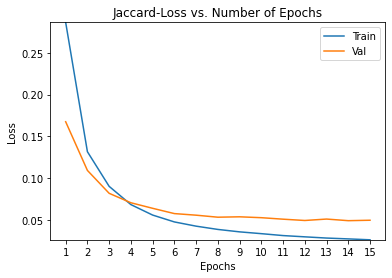

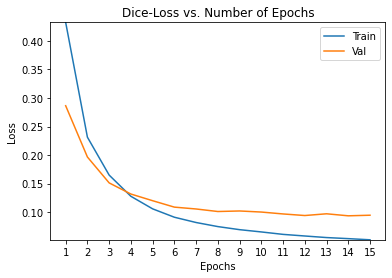

In [ ]:
#Add graphs to plot val / train loss against epochs
#Add tables for confusion matrix, AUROC etc.

NUM_EPOCHS = epochs

plt.title("Jaccard-Loss vs. Number of Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,NUM_EPOCHS+1),tr_loss,label="Train")
plt.plot(range(1,NUM_EPOCHS+1),val_loss,label="Val")
plt.ylim(min(val_loss+tr_loss),max(val_loss+tr_loss))
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
plt.legend()
plt.show()

plt.title("Dice-Loss vs. Number of Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,NUM_EPOCHS+1),tr_loss2,label="Train")
plt.plot(range(1,NUM_EPOCHS+1),val_loss2,label="Val")
plt.ylim(min(val_loss2+tr_loss2),max(val_loss2+tr_loss2))
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
plt.legend()
plt.show()


In [ ]:
# Evaluating trained model on test set

TEST_IMG_PATH = '/content/HAM10000_images_split/test'
TEST_MASK_PATH = '/content/HAM10000_segmentations_split/test'

class TestSegmentationLoader(data.Dataset):
    def __init__(self):
        super(TestSegmentationLoader, self).__init__()
        IMAGE_PATH = TEST_IMG_PATH
        MASK_PATH = TEST_MASK_PATH
        self.img_files = glob.glob(os.path.join(IMAGE_PATH, '*.jpg'))
        self.mask_files = []
        for img_path in self.img_files:
            self.mask_files.append(os.path.join(MASK_PATH, Path(img_path).stem) + '_segmentation.jpg')

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        img_name = Path(img_path).stem
        data = Image.open(img_path)
        data = np.array(data.getdata()).reshape(1,448,448,3)
        data = np.transpose(data, (0, 3 ,1 , 2))
        label = Image.open(mask_path)
        label = label.convert('1') # convert mask to black white      
        label = np.array(label.getdata()).reshape(1,448,448)
        return img_name, torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)


In [ ]:
batch_size=16
test_ds = TestSegmentationLoader()
test_dl = data.DataLoader(dataset=test_ds,
                                      batch_size=batch_size,
                                      shuffle=False)
mask_img = []
mask_names = []

running_loss1 = 0.0
running_loss2 = 0.0
#running_acc = 0.0

for img, x, y in tqdm(test_dl):
  x = x.squeeze(1).to(device)
  x = x / x.max()
  y = y.squeeze(1).to(device)
  y = y / y.max()

  with torch.no_grad():
    outputs = model(x)
    loss1 = jacc_loss(outputs, y.long()) #Set Loss1
    loss2 = dice_loss(outputs, y.long()) #Set Loss2
  
  mask_img.append(outputs)
  mask_names.append(img[0])
  
  #acc = acc_metric(outputs, y)
  #running_acc  += float(acc) * batch_size
  running_loss1 += float(loss1) * batch_size
  running_loss2 += float(loss2) * batch_size
              
epoch_loss1 = running_loss1 / len(test_dl.dataset)
epoch_loss2 = running_loss2 / len(test_dl.dataset)
#epoch_acc = running_acc / len(test_dl.dataset)

print('Test Jaccard-Loss: {:.4f} Test Dice-Loss: {:.4f}'.format(epoch_loss1, epoch_loss2))




Test Jaccard-Loss: 0.0936 Test Dice-Loss: 0.0493


In [ ]:
def threshold(img):
    thresh_img = torch.where(img>=0.5, 1, 0)
    return thresh_img.cpu()

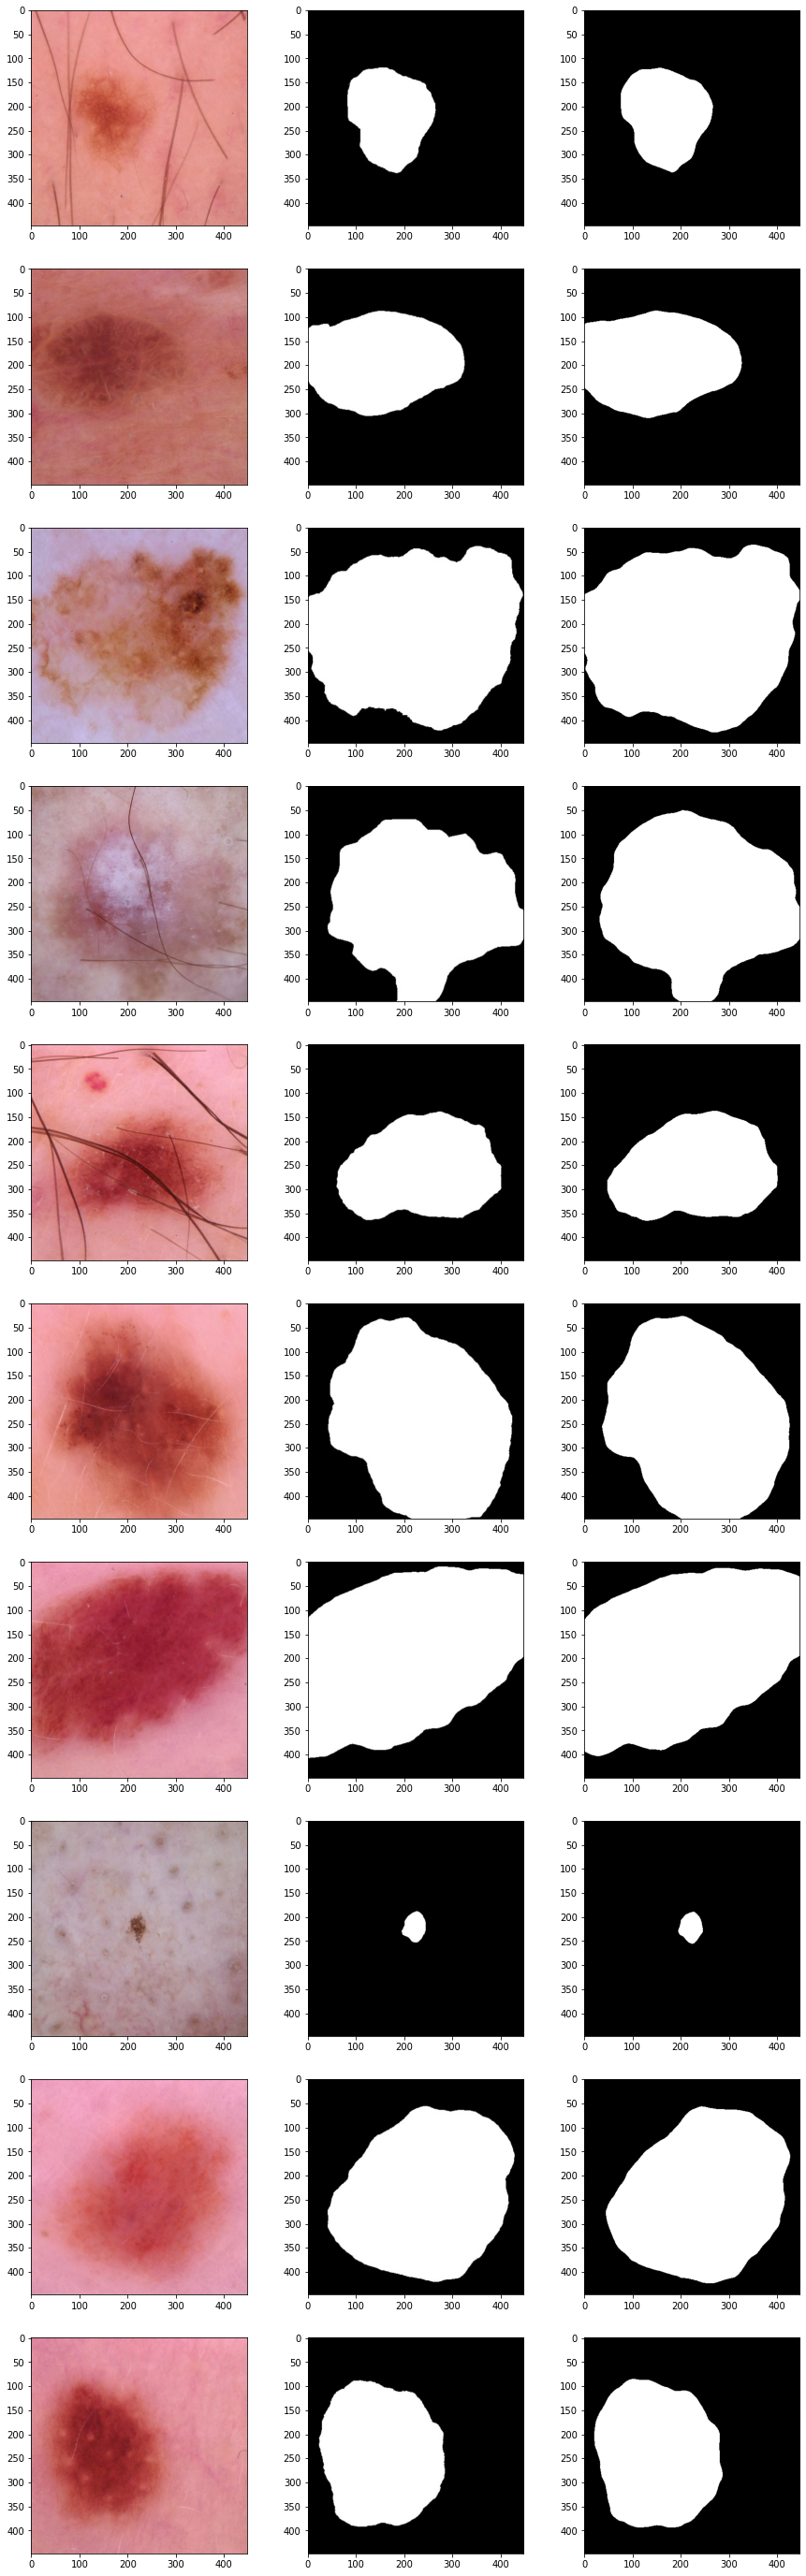

In [ ]:
#Visualize model predictions, left: original image, middle: ground truth mask, right: predicted mask

numbers = 10
fig, ax = plt.subplots(numbers,3, figsize=(15,numbers*5))

for i in range(numbers):
    image = Image.open(os.path.join(TEST_IMG_PATH, f'{mask_names[i]}.jpg'))
    mask = Image.open(os.path.join(TEST_MASK_PATH, mask_names[i]) + '_segmentation.jpg')
    prediction = threshold(mask_img[i].squeeze())
    
    ax[i,0].imshow(image)
    ax[i,1].imshow(mask)
    ax[i,2].imshow(prediction, cmap='binary_r')
